In [2]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import statsmodels.api as sm
import numpy as np
import pingouin as pg
sns.set(rc={"figure.dpi":150, 'savefig.dpi':150})
sns.set_context('notebook')
sns.set_style("ticks")


/usr/local/lib/python3.8/dist-packages/outdated/utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.0, the latest is 0.2.1.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
/usr/local/lib/python3.8/dist-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.8, the latest is 0.5.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


# Functions

In [52]:
# ------------------------------------------------------------------------------------------------------------
# Cleaning functions
# ------------------------------------------------------------------------------------------------------------
def get_max_payoff(f1, f2, cost1=0, cost2=0):
    data = np.zeros((11-cost2, 11-cost1))
    for i in range(11-cost1):
        for j in range(11-cost2):
            data[j, i] = 10 - i - cost1 + ((i*f1 + j*f2)/2)
    return np.amax(data)


def add_max_payoff(df, cost=None):
    group_ids = df['group_id'].unique()
    f1, f2 = sorted(df['multiplier'].unique())
    df['max_payoff'] = np.NaN
    matching = {}
    for m1, m2 in ((f1, f2), (f1, f1), (f2, f1), (f2, f2)):
        matching[(m1, m2)] = [get_max_payoff(m1, m2), get_max_payoff(m2, m1)]

    for g in group_ids:
        d = df[df['group_id'] == g]
        if len(d) == 2:
            idx = d.index.tolist()
            t1 = d.iloc[0]['multiplier']
            t2 = d.iloc[1]['multiplier']
            c1 = d.iloc[0]['disclose']
            c2 = d.iloc[1]['disclose']

            max_payoff = matching[t1, t2]

            if cost:
                max_payoff = [get_max_payoff(t1, t2, cost1=cost*c1, cost2=c2*cost),
                              get_max_payoff(t2, t1, cost1=cost*c2, cost2=c1*cost)]

            df.loc[idx[0], 'max_payoff'] = max_payoff[0]
            df.loc[idx[1], 'max_payoff'] = max_payoff[1]
    return df


def add_norm_payoff(df):
    df['norm_payoff'] = df['payoff']/df['max_payoff']
    return df


def remove_bots(df):
    prolific_id_to_exclude = df[df['rt1'] == -1]['prolific_id'].unique()
    df = df[~df['prolific_id'].isin(prolific_id_to_exclude)]
    return df


def add_subjects(df, num):
    df['id_in_session'] = df['id_in_session'] + (num*100)
    return df


def remove_bots_but_keep_previous_rows(df):
    return df[df['rt1'] != -1]


def remove_trials_where_both_players_are_bots(df):
    group_ids = df['group_id'].unique()
    for g in group_ids:
        d = df[df['group_id'] == g]
        idx = d.index.tolist()
        rt1 = d.iloc[0]['rt1'] == -1
        rt2 = d.iloc[1]['rt1'] == -1
        if rt1 and rt2:
            df = df.drop(idx)
    return df


def remove_incomplete_sub(df, n):
    count = 0
    for i in df['prolific_id'].unique():
        count += len(df[df['prolific_id'] == i]) == n
        if len(df[df['prolific_id'] == i]) != n:
            df = df[df['prolific_id'] != i]
    return df, count


# Data clearning

In [58]:
exp = [
    'data/' + f for f in
    ['theresa_sorting.csv',
     'theresa_control.csv',
     'theresa_with_cost.csv',
     'theresa_single.csv']
]

dfs = [pd.read_csv(f) for f in exp]

for i, d in enumerate(dfs):
    dfs[i] = remove_bots(dfs[i].copy())
    dfs[i], count = remove_incomplete_sub(
        df=dfs[i].copy(), n=63 if i == 3 else 60)
    print(i, count)
    # df['prolific_id']


0 30
1 22
2 23
3 56


/tmp/ipykernel_9452/3858379498.py:23: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  plt.gca().spines['left'].set_smart_bounds(True)
/tmp/ipykernel_9452/3858379498.py:24: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  plt.gca().spines['bottom'].set_smart_bounds(True)


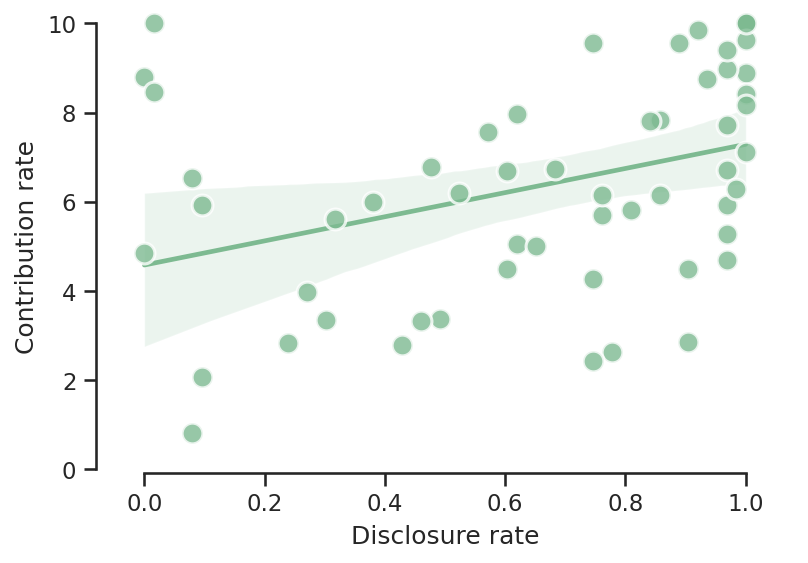

                            OLS Regression Results                            
Dep. Variable:           contribution   R-squared:                       0.136
Model:                            OLS   Adj. R-squared:                  0.120
Method:                 Least Squares   F-statistic:                     8.521
Date:                Tue, 16 Aug 2022   Prob (F-statistic):            0.00511
Time:                        14:45:38   Log-Likelihood:                -124.66
No. Observations:                  56   AIC:                             253.3
Df Residuals:                      54   BIC:                             257.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.5818      0.682      6.718      0.0

In [68]:
selected_exp = 3
df = dfs[selected_exp]

x = df.groupby(['prolific_id'], as_index=True)['disclose'].mean()
y = df.groupby(['prolific_id'], as_index=True)['contribution'].mean()


X = sm.add_constant(x)
model = sm.OLS(y, X).fit()

y2 = model.predict(X)

sns.set_palette('crest')
sns.regplot(
    x=x,
    y=y, scatter_kws={'clip_on': False, 'zorder': 10, 'edgecolor': 'white', 'lw': 1.5, 's': 100})
plt.ylabel('Contribution rate')
plt.xlabel('Disclosure rate')
plt.xlim([-0.08, 1.08])
plt.ylim([-0.08, 10.08])
sns.despine()

plt.gca().spines['left'].set_smart_bounds(True)
plt.gca().spines['bottom'].set_smart_bounds(True)

plt.show()
print(model.summary())


KeyError: 'opp_multiplier'

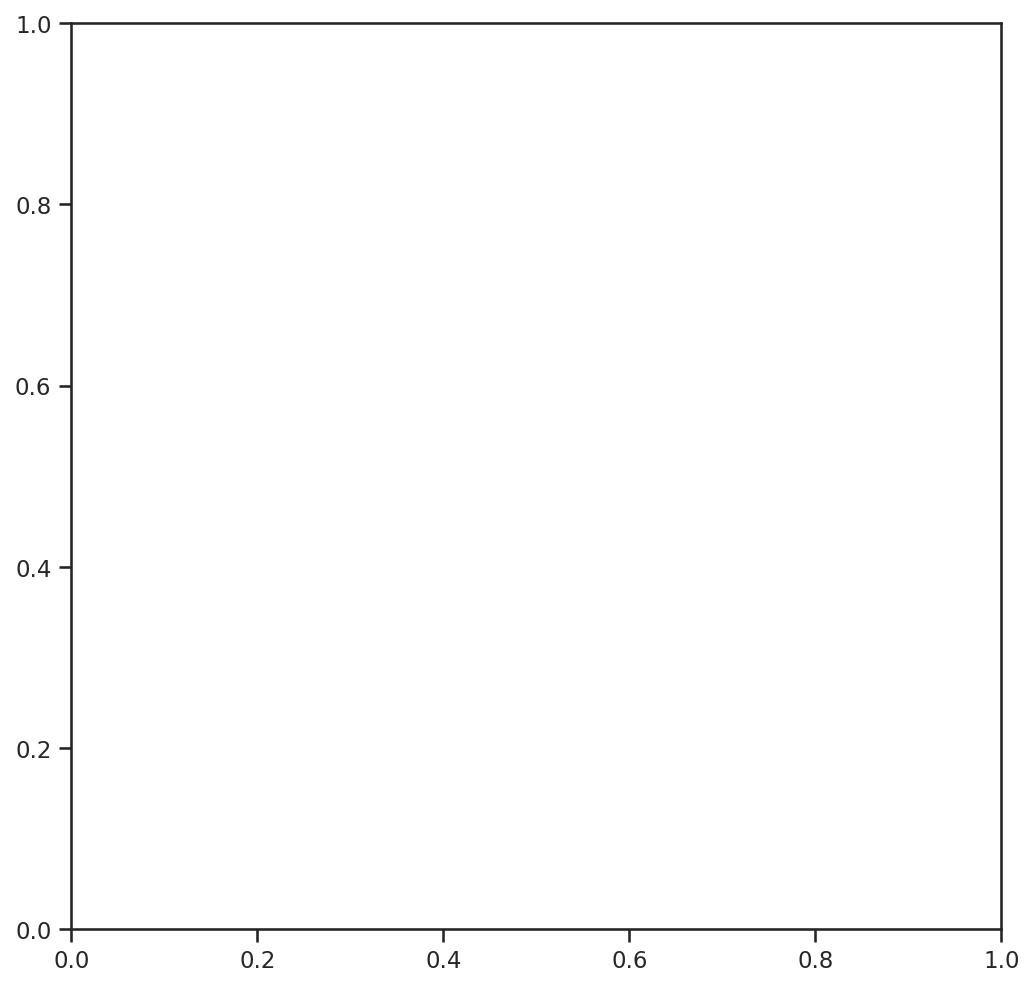

In [64]:
selected_exp = 0
df = dfs[selected_exp]

vd = 'contribution'

fig, ax = plt.subplots(figsize=(8, 8))

df2 = df.groupby(['prolific_id', 'multiplier',
                    'opp_multiplier'], as_index=False)[vd].mean()

sns.set_palette("crest")
sns.barplot(
    x='multiplier',
    y=vd,
    hue='opp_multiplier', data=df2, ci=68,
    edgecolor="white",
    errcolor="black",
    errwidth=1.5,
    capsize=0.05,
    alpha=0.5, ax=ax)

sns.stripplot(
    x='multiplier',
     y=vd, hue='opp_multiplier', data=df2, dodge=True,
              jitter=True, ax=ax, alpha=0.5, size=10, edgecolor='white', linewidth=1)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[2:], labels[2:], title='opp_multiplier',
          bbox_to_anchor=(1, 1.02), loc='upper left')
sns.despine(right=True, top=True)

plt.ylabel(f'average {vd}')

plt.gca().spines['left'].set_smart_bounds(True)
plt.gca().spines['bottom'].set_smart_bounds(True)

df3 = df.groupby(['prolific_id', 'multiplier'], as_index=False)[vd].mean()

pg.ttest(x=df3[df3['multiplier'] == 1.5][vd],
         y=df3[df3['multiplier'] == 2.5][vd])


/tmp/ipykernel_1390151/2040947798.py:20: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  plt.gca().spines['left'].set_smart_bounds(True)
/tmp/ipykernel_1390151/2040947798.py:21: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  plt.gca().spines['bottom'].set_smart_bounds(True)


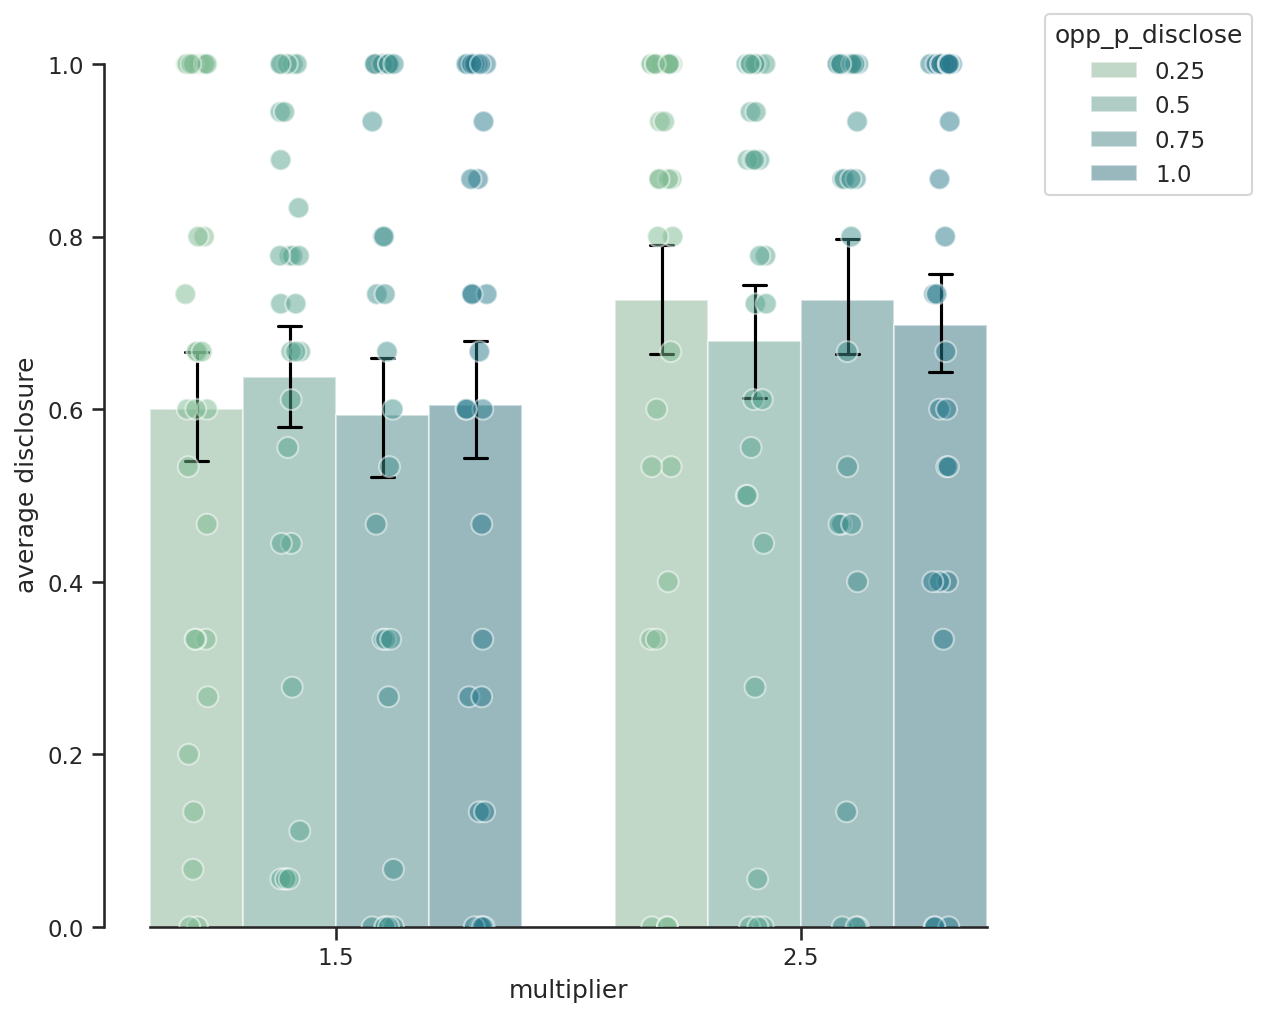

In [8]:
fig, ax = plt.subplots(figsize=(8, 8))
df2 = df.groupby(['prolific_id', 'opp_p_disclose', 'multiplier'], as_index=False)['disclose'].mean()

sns.set_palette("crest")
sns.barplot(x='multiplier', y='disclose', hue='opp_p_disclose', data=df2, ci=68, 
    edgecolor="white",
    errcolor="black",
    errwidth=1.5,
    capsize = 0.05,
    alpha=0.5, ax=ax)

sns.stripplot(x='multiplier',y='disclose', hue='opp_p_disclose', data=df2, dodge=True, jitter=True, ax=ax, alpha=0.5, size=10, edgecolor='white', linewidth=1)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[4:], labels[4:], title='opp_p_disclose', bbox_to_anchor=(1, 1.02), loc='upper left')
sns.despine(right=True, top=True)

plt.ylabel('average disclosure')

plt.gca().spines['left'].set_smart_bounds(True)
plt.gca().spines['bottom'].set_smart_bounds(True)



In [1]:

fig, ax = plt.subplots(figsize=(8, 8))
df2 = df.groupby(['prolific_id', 'opp_multiplier', 'multiplier'], as_index=False)['contribution'].mean()
print(len(df2))

sns.barplot(x='multiplier', y='contribution', hue='opp_multiplier', data=df2, ci=68, 
    edgecolor="white",
    errcolor="black",
    errwidth=1.5,
    capsize = 0.05,
    alpha=0.5, ax=ax)

sns.stripplot(x='multiplier',y='contribution', hue='opp_multiplier', data=df2, dodge=True, jitter=True, ax=ax, alpha=0.5)

# pg.pairwise_ttests(dv='contribution', between='multiplier', within=['opp_multiplier'n ] data=df2, correction='bonf', within_first=True)
# handles, labels = ax.get_legend_handles_labels()
# ax.legend(handles[4:], labels[4:], title='opp_p_disclose', bbox_to_anchor=(1, 1.02), loc='upper left')

NameError: name 'plt' is not defined

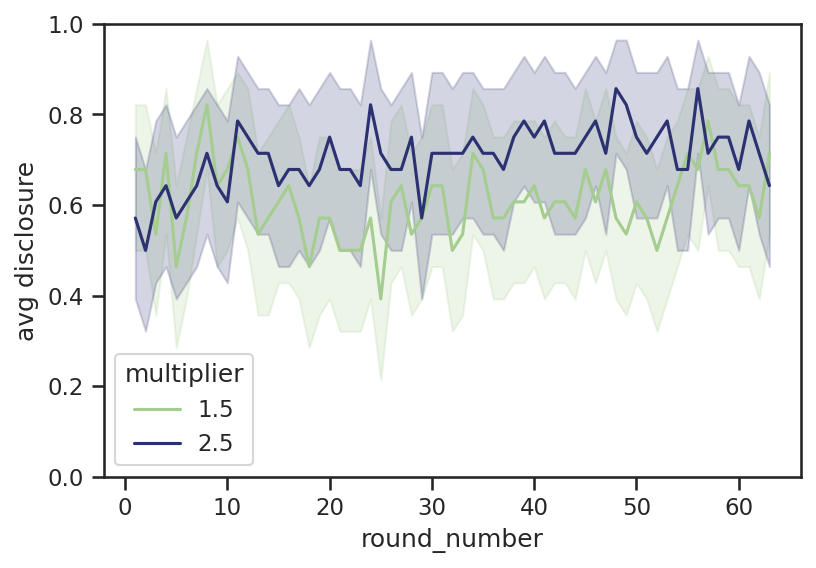

In [10]:

sns.set_palette("crest")

# Plot the responses for different events and regions
sns.lineplot(x="round_number", y="disclose",
             hue="multiplier", 
             data=df, palette='crest')
plt.ylim([0, 1])
plt.ylabel('avg disclosure')
plt.show()